# In this notebook, we compile all programs used to generate power from tree trunk temperature differences. To run the code, hit "Run" above, and make sure to run all cells above the target cell.

## The structure of the notebook is :

  1. import all libraries and packages
  2. import all data files in csv format
  3. define hyperparameters
  4. define parameters
  5. generate boundary condition data
  6. main time stepping code
  7. compute generated current
  8. visualization

Import packages; numpy and scipy are for simulations; pandas for reading data; matplotlib and mpl_tookits.mplot3d for visualization. All experiments are run in Python3.

In [1]:
import numpy as np
import pandas
from scipy import sparse
from scipy.optimize import broyden1
from functools import partial
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib inline

import sys
print("Python 3 version is", sys.version)
import matplotlib
print("Matplotlib version is", matplotlib.__version__)
print("Numpy version is", np.__version__)
import scipy

print("Scipy version is", scipy.__version__)

Python 3 version is 3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Matplotlib version is 3.1.1
Numpy version is 1.17.2
Scipy version is 1.3.1


Define parameters used in time stepping- related to the properties of the trees and weather: thermal conductivity (W/(mK), $\rho$ the density (kg/m^3), specific heat (J/(kgK)); $\rho$ mutiplies specific heat gives the heat capacity; finally
albedo which impacts how much solar radiation is absorbed (taken to be 0.3 from Potter and Andresen 2002).

We choose a constant thermal conductivity, as numerical experiments show little difference.

In [2]:
#Define parameters
"""
n_x -- number of grid points, radially; interior points index from 1 to n_x - 1; bdry points are 0 and n_x.
n_t -- number of time steps
plot_at -- grid point at which a temperature curve is drawn
diff_at -- list of two grid points where the temp difference is computed
radius -- radius of tree, m
height -- height of tree, m
thermal_conductivity -- thermal conductivity of the tree, unit W/(mK)
rho -- density of tree trunk, unit kg/m^3
specific_heat -- specific_heat, unit J/(kgK)
albedo -- albedo constant; taken to be 0.3 from Potter Andresen pg.3
sigma -- Stefan–Boltzmann constant, 5.67 × 10 − 8 W ⋅ m − 2 ⋅ K − 4
"""
# test with n_x = 160 and n_t = 10
parameters = {"n_x": 160,
              "n_t": 1000,
              "sigma":5.76e-8,
              "plot_at": 3,
              "diff_at": [1, -3],
              "radius": 0.18,
              "height": 10,
              "thermal_conductivity": 0.12, # Notation Kt
              "rho": 510,
              "specific_heat": 1380,
              "albedo": 0.3} 

In [3]:
## testing cell

print(parameters)
print(parameters["n_x"])
print(type(parameters["radius"]))


n_t = parameters["n_t"]
time = np.linspace(0, 24, n_t, endpoint = False)
dt = time[1] - time[0]
    
n_x = parameters["n_x"]
radius = parameters["radius"]
    # Boundary conditions at trunk[0] and trunk[n_x]; Temperature[j] at trunk[j]; in matrix, only index from 1 to n_x-1 (labeled m)
trunk = np.linspace(0, radius, n_x+1)   
dr = radius / n_x
dr1 = trunk[1] - trunk[0]

print(dr - dr1)

{'n_x': 160, 'n_t': 1000, 'sigma': 5.76e-08, 'plot_at': 3, 'diff_at': [1, -3], 'radius': 0.18, 'height': 10, 'thermal_conductivity': 0.12, 'rho': 510, 'specific_heat': 1380, 'albedo': 0.3}
160
<class 'float'>
0.0


Define hyperparameters- these are non-physical parameters whose values are used to control the simulation process via the Crank-Nicolson method. In particular, we define the number of grid points, and the number of time steps. There is no built-in CFL check, as Crank-Nicolson is unconditionally stable. 

**Need to look at the definition of n_t**

In [4]:
# testing cell for index study; delete when done

r = 0.18
n_x = 160
trunk = np.linspace(0, r, n_x + 1)
itemindex = np.where(trunk==trunk[-2])
print(trunk[0],trunk[1],trunk[-1],trunk[n_x],trunk.shape,itemindex,trunk[itemindex],trunk[itemindex] + trunk[1])

0.0 0.001125 0.18 0.18 (161,) (array([159]),) [0.178875] [0.18]


Import data from TNTweather.csv; we use data within 24 hours from Feb 16, 2021. Data includes date, time, temperature (ambient), windspeed, and solar radiation; measured starting from 0 am to 23:59pm. With piece wise linear interpolation. This piece is hard coded due to the format of data.

In [5]:
def make_weather_input(parameters):
    
    n_t = parameters["n_t"]
    
    colnames = ['date', 'time', 'temperature', 'windspeed', 'solar']

    dataWeather = pandas.read_csv('TNTweather.csv', names = colnames)

    #date16 = dataWeather.date[4:27].tolist()
    #time16 = dataWeather.time[4:27].tolist()

    temp16 = dataWeather.temperature[4:27].tolist() # row 6 ro 29
    temp16np = np.asarray([float(t) for t in temp16])

    windspeed16 = dataWeather.windspeed[4:27].tolist()
    windspeed16np = np.asarray([float(v) for v in windspeed16])

    solar16 = dataWeather.solar[4:27].tolist()
    solar16np = np.asarray([float(v) for v in solar16])

    air_temp = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,temp16np.size),temp16np)
    windspeed = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,windspeed16np.size),windspeed16np)
    solar = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,solar16np.size),solar16np)
    
    weather_input = {"air_temp": air_temp,
                  "windspeed": windspeed,
                  "solar": solar}
    return weather_input

In [6]:
# to run in code: weather_input = weather_input(hyper_parameters["n_t"])
# weather_input = make_weather_input(parameters)
# print("air_temp = " + str(weather_input["air_temp"]))
# print("windspeed = " + str(weather_input["windspeed"]))
# print("solar = " + str(weather_input["solar"]))

# print(type(weather_input["solar"]))

Import tree temperature data from Protasio, including core and bark temperature; use data measured within 24 hours from Feb 16, 2021.

In [7]:
def make_temp_input(parameters):
    n_t = parameters["n_t"]
    colnames = ['date1', 'time1', 'barkTemp', 'coreTemp']
    
    dataTemp = pandas.read_csv('TNTtemp.csv', names=colnames)
    
    #datet16 = dataTemp.date1[367:781].tolist()
    #timet16 = dataTemp.time1[367:781].tolist()

    coreTemp16 = dataTemp.coreTemp[367:781].tolist() # row 6 ro 29
    coreTemp16np = np.asarray([float(t) for t in coreTemp16])

    barkTemp16 = dataTemp.barkTemp[367:781].tolist()
    barkTemp16np = np.asarray([float(v) for v in barkTemp16])
    
    bark_temp = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,barkTemp16np.size),barkTemp16np)
    core_temp = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,coreTemp16np.size),coreTemp16np)
    diff_temp = np.average(bark_temp - core_temp)
    
    temp_input = {"bark_temp": bark_temp,
                  "core_temp": core_temp,
                  "diff_temp": diff_temp}
    
    return temp_input    

In [8]:
# temp_input = make_temp_input(parameters)
# print("bark_temp = " + str(temp_input["bark_temp"]))
# print("core_temp = " + str(temp_input["core_temp"]))
# print("diff_temp = " + str(temp_input["diff_temp"]))

In the one dimensional model, we see that temperature distribution depends on time $t$ and distance from the center $r$. 

\begin{equation}
\rho c\frac{\partial T}{\partial t}=\frac{1}{r}\frac{\partial}{\partial r}\bigg(kr\frac{\partial T}{\partial r}\bigg)+\text{ source terms}
=\frac{\partial k}{\partial r}\frac{\partial T}{\partial r}+\frac{k}{r}\frac{\partial T}{\partial r}+k\frac{\partial^2T}{\partial r^2}+\text{ source terms}.\label{heat1d}
\end{equation}

In the equation, $\rho$ represents density of the tree trunk; $c$ is the specific heat, and $k$ the thermal conductivity. 

Let $T^n_{i} \approx T(r_i,t_n)$ denote the numerical solution at the point $(r_i,t_n)$, $\Delta t$ the time step, and $\Delta r$ grid size. In this formulation, we have taken the thermal conductivity to be constant within the tree trunk. We denote the total source term to be $g_s(r,t)$, and use the source value $g_s(t)\frac{1}{\Delta r}$, because the sources are all surface energy fluxes, while the conduction terms apply to the model element volume. **experiment with/out division of Delta r**. For equation (2), try $\frac{1}{2\rho c}(g_s(r_i,t) + g_s(r_i,t+\Delta t))$ or $\frac{1}{2\rho c\Delta r}(g_s(r_i,t) + g_s(r_i,t+\Delta t))$.


With second order central difference in space 
\begin{equation}\frac{\partial T}{\partial r}\approx\frac{T_{i+1}-T_{i-1}}{2\Delta r}\end{equation}
\begin{equation}\frac{\partial^2 T}{\partial r^2}\approx\frac{T_{i-1}-2T_{i}+T_{i+1}}{(\Delta r)^2}\end{equation}
and first order forward in time
\begin{equation}\frac{\partial T}{\partial t}\approx\frac{T^1-T^0}{\Delta t},\end{equation}
we obtain the Crank-Nicolson method by averaging the above spatial differences in time (no source):
\begin{align}
&(T^{n+1}_i - T^n_i)/\Delta t = 1/(4ar_i\Delta r)(T^n_{i+1}-T^n_{i-1} + T^{n+1}_{i+1}-T^{n+1}_{i-1} )\nonumber\\
&+1/(2a(\Delta r)^2)(T^n_{i-1} - 2T^n_i + T^n_{i+1} + T^{n+1}_{i-1} - 2T^{n+1}_i + T^{n+1}_{i+1}),\ (1)\label{1dCNscheme}
\end{align}
where $a = \frac{\rho c}{k}$. With the source value, we obtain

\begin{align}
&(T^{n+1}_i - T^n_i)/\Delta t = 1/(4ar_i\Delta r)(T^n_{i+1}-T^n_{i-1} + T^{n+1}_{i+1}-T^{n+1}_{i-1} )\nonumber\\
&+1/(2a(\Delta r)^2)(T^n_{i-1} - 2T^n_i + T^n_{i+1} + T^{n+1}_{i-1} - 2T^{n+1}_i + T^{n+1}_{i+1})+\frac{1}{2\rho c\Delta r}(g_s(r_i,t) + g_s(r_i,t+\Delta t)),\ (2)\label{1dCNschemeSource}
\end{align}

Separating terms from two time steps gives the following
\begin{equation}
\alpha_i T^1_{i-1} +(1+\beta)T^1_i-\gamma_iT^1_{i+1}=-\alpha_i T^0_{i-1} +(1-\beta)T^0_i+\gamma_iT^0_{i+1}+\frac{\Delta t}{2\rho c\Delta r}(g_s(r_i,t) + g_s(r_i,t+\Delta t)),\ (3)\end{equation}
where $\beta = \frac{\Delta t}{a(\Delta r)^2}$, $\alpha_i = \frac{\Delta t}{4ar_i\Delta r}-\frac{\Delta t}{2a(\Delta r)^2}$, and $\gamma_i = \frac{\Delta t}{4ar_i\Delta r}+\frac{\Delta t}{2a(\Delta r)^2}$

We implement two types of boundary conditions at the inner boundary:

1. no-flux condition (Neumann)
\begin{equation}
    \frac{\partial T}{\partial r}\bigg|_{r=0}=0,
\end{equation} 

for numerical simplicity (referenced in FireStem2D). Numerically, we use the second order central difference approximation $ \frac{\partial T}{\partial r}\bigg|_{r=0}\approx \frac{T_2-T_0}{2\Delta r}=0$, and the above equation gives a representation for the ghost cell value $T_0$ in terms of $T_2$. 

2. we enforce experimental data measured at the center of the tree trunk (Dirichlet)
\begin{equation}
    T(r=0, t)=g_0(t),\ \text{ where $g_0(t)$ is the measured data},
\end{equation} 

For the outer boundary, we implement three types of Dirichlet boundary condition:

1. with experimental data measured at location
\begin{equation}
    T(r=R, t)=g_1(t),\ \text{ measured data},
\end{equation} 

2. with experimental data measured at location, but approximated by the measured air temperature.
\begin{equation}
    T(r=0, t)=T_{air}(t),\ \text{ approximate air temperature},
\end{equation} 

3. with simulated data generated with the steady state solution.
\begin{equation}
    T(r=0, t)=T_{simulated}(t),\ \text{ simulated data},
\end{equation} 

The first row of the following matrix equation implements the inner boundary condtion, and the last row the outter boundary condition. The source term is also added to the last row. 

The following equations are similar to equation (9.9) in LeVeque's book on Finite Difference methods. Here the matrix is of size $(n_x -1)\times (n_x -1)$, with $T[0]$ the core and $T[n_x]$ the bark temperature that we do not solve- these are either read from experimental data, or simulated from weather data and pre obtained parameters. Here the index satisfies $n_x-1=m$. (for example, when $n_x = 160$, $m=159$,we solve for temperature values indexed 1 to 159)

If we apply Neumann condition at the center, and Dirichlet boundary condition at the tree bark:

\begin{equation*}
    \left( \begin{array}{cccc}
1+\beta & -\beta & & 0\\
\alpha_2 & 1+\beta & -\gamma_2 & \\
\ddots& \ddots & \ddots  & \\
& \alpha_{m-1} & 1+\beta & -\gamma_{m-1} \\
0 & & \alpha_m & 1+\beta \end{array} \right)\left(\begin{array}{c}
     T^1_1  \\
     T^1_2 \\
     \vdots\\
     T^1_{m-1}\\
     T^1_m
\end{array}\right)=\left( \begin{array}{cccc}
1-\beta & \beta & & 0\\
-\alpha_2 & 1-\beta & \gamma_2 & \\
\ddots& \ddots & \ddots  & \\
& -\alpha_{m-1} & 1-\beta & \gamma_{m-1} \\
0 & & -\alpha_m & 1-\beta \end{array} \right)\left(\begin{array}{c}
     T^0_1  \\
     T^0_2 \\
     \vdots\\
     T^0_{m-1}\\
     T^0_m
\end{array}\right)+\left(\begin{array}{c}
     0  \\
     0 \\
     \vdots\\
     0\\
     \gamma_m(g_1(t)+g_1(t+\Delta t))+\frac{\Delta t}{2\rho c\Delta r}(g_s(t)+g_s(t+\Delta t))
\end{array}\right).
\end{equation*}


Notice that the first row of the matrix represents the inner boundary condition: we first approximate $\partial T/\partial r \approx (T_2-T_0)/(2\Delta r)=0$, then the relation involving $T_1$ and $T_2$ is derived from equation (2) using $T_0 = T_2$. 

The last row of the matrix represents the outer boundary condition: $T(r = R, t) = g_1(t)$, and equation (2) implies
\begin{equation}
\alpha_m T^1_{m-1}+(1+\beta)T^1_m-\gamma_mg_1(t+\Delta t)=-\alpha_m T^0_{m-1}+(1-\beta)T^0_m+\gamma_mg_1(t)
\end{equation}
when we replace the ghost cell $T(r = R+\Delta r, t) \approx T^0_{m+1}$ by $g_1(t)$, and this becomes 
\begin{equation}
\alpha_m T^1_{m-1}+(1+\beta)T^1_m=-\alpha_m T^0_{m-1}+(1-\beta)T^0_m+\gamma_m(g_1(t) +g_1(t+\Delta t))
\end{equation}

**idea: try integrate Matlab and use ode23/45 for MOL**

Similarly, if we apply Dirichlet boundary condition at both the center and the tree bark,

\begin{equation*}
    \left( \begin{array}{cccc}
1+\beta & -\gamma_1 & & 0\\
\alpha_2 & 1+\beta & -\gamma_2 & \\
\ddots& \ddots & \ddots  & \\
& \alpha_{m-1} & 1+\beta & -\gamma_{m-1} \\
0 & & \alpha_m & 1+\beta \end{array} \right)\left(\begin{array}{c}
     T^1_1  \\
     T^1_2 \\
     \vdots\\
     T^1_{m-1}\\
     T^1_m
\end{array}\right)=\left( \begin{array}{cccc}
1-\beta & \gamma_1 & & 0\\
-\alpha_2 & 1-\beta & \gamma_2 & \\
\ddots& \ddots & \ddots  & \\
& -\alpha_{m-1} & 1-\beta & \gamma_{m-1} \\
0 & & -\alpha_m & 1-\beta \end{array} \right)\left(\begin{array}{c}
     T^0_1  \\
     T^0_2 \\
     \vdots\\
     T^0_{m-1}\\
     T^0_m
\end{array}\right)+\left(\begin{array}{c}
     -\alpha_1(g_0(t)+g_0(t+\Delta t))  \\
     0 \\
     \vdots\\
     0\\
     \gamma_m(g_1(t)+g_1(t+\Delta t))+\frac{\Delta t}{2\rho c\Delta r}(g_s(t)+g_s(t+\Delta t))
\end{array}\right).
\end{equation*}

Define the right hand side vectors for Neumann and Dirichlet conditions. Consider the system $AT^1 = BT^0 + v$, first row of $v$ would be 0 if Neumann at the core; and $-\alpha_1(T^1_0+T^0_0)$ if Dirichlet at core. Since both formulation uses Dirichlet outter boundary condition, and source terms are also at the bark, the last row in both cases is $\gamma_m(T^1_{m+1}+T^0_{m+1})+\frac{\Delta t}{2\rho c}(f_s(R,t)+f_s(R,t + \Delta t))$

In [9]:
# matrix needs to be made so that it is of size n_x - 1 by n_x - 1. m = n_x - 1

def time_stepping(parameters, bdry_type):
    
    sigma = 5.67e-8
    
    k = parameters["thermal_conductivity"]
    albedo = parameters["albedo"]
    n_x = parameters["n_x"]
    n_t = parameters["n_t"]
    radius = parameters["radius"]
    rho = parameters["rho"]
    specific_heat = parameters["specific_heat"]
    
    ### make utilities
    time = np.linspace(0, 24, n_t, endpoint = False)
    dt = time[1] - time[0]
    # Boundary conditions at trunk[0] and trunk[n_x]; Temperature[j] at trunk[j]; in matrix, only index from 1 to n_x-1 (labeled m)
    trunk = np.linspace(0, radius, n_x + 1)   
    dr = radius / n_x
    #dr = trunk[1] - trunk[0]
    
    heat_capacity = rho * specific_heat
    
    a = heat_capacity / k
    beta = dt / (a * dr ** 2)
    coeffSource = dt / (2 * heat_capacity)
    
    # import bdry condition
    temp_input = make_temp_input(parameters)
    core_temp = temp_input["core_temp"]
    bark_temp = temp_input["bark_temp"]
    
    # import weather condition
    weather_input = make_weather_input(parameters)
    air_temp = weather_input["air_temp"]
    windspeed = weather_input["windspeed"]
    solar = weather_input["solar"]
    
    # use h = 21 as an estimate
    h = 21
    convect = h * (air_temp - bark_temp)
    
    """
    compute source terms and then sum
    solar radiation = (1-albedo) * solar
    blackbody/long radiation = sigma * (Tair^4 - Tsfc^4)
    convection = h * (Tsfc - Tair)
    """
    # convect might change based on experimental data to reflect h * (Tsfc - Tair)

    sourceTerm = (1 - albedo) * solar + sigma * (air_temp**4 - bark_temp**4) + convect
    
    T0 = 300.40 * np.ones(n_x) # initialize temperature with an estimate temperature

    
    alpha = np.linspace(1, n_x - 1, n_x - 1)# index from 0 to n_x - 2; cor. to points at 1 to n_x - 1
    for j in range(alpha.size):
        alpha[j] = dt / (4 * a * trunk[j + 2] * dr) - 0.5 * beta
    
    gamma = np.linspace(1, n_x - 1, n_x - 1)
    for j in range(gamma.size):
        gamma[j] = dt / (4 * a * trunk[j + 1] * dr) + 0.5 * beta
    
    # for the right hand side vector- alpha1 if Dirichlet at center; gammam is used for Dirichlet at the bark
    
    alpha1 = dt / (4 * a * trunk[1] * dr) - 0.5 * beta
    gammam = dt / (4 * a * trunk[-1] * dr) + 0.5 * beta
    
#     vAddm = gammam * () + coeffSource * ()
    # system of Ax_{n+1} = Bx_{n} + v    
    
    if bdry_type == "neumann":
        gamma[0] = beta  # define inner neumann bdry condition 1st row
        
   
    elif bdry_type == "dirichlet": 
        gamma[0] = dt / (4 * a * trunk[1] * dr) + 0.5 * beta

#     print(bdry_type, gamma[0])
    A = sparse.diags([alpha, np.ones(n_x) + beta, -gamma], [-1, 0, 1], shape=(n_x, n_x)).toarray()
    B = sparse.diags([-alpha, np.ones(n_x) - beta, gamma], [-1, 0, 1], shape=(n_x, n_x)).toarray()
    
    T1 = np.zeros((n_x,1))
    
    # soln to include initial temperature
    soln = [T0]
    
    ## time stepping: step1 compute B * T0; step2 rhs = B * T0 + v; step2 solve for T1 with T1 = A^-1 * rhs
    for time in range(n_t - 1):
        rhs = B.dot(T0)
        rhs[-1] = rhs[-1] + gammam * (bark_temp[time] + bark_temp[time + 1]) + coeffSource * (sourceTerm[time] + sourceTerm[time + 1])
        if bdry_type == "dirichlet": 
            rhs[0] = rhs[0] - alpha1 * (core_temp[time] + core_temp[time + 1])
        
        T1 = np.linalg.solve(A, rhs) 
        T0 = T1
        
        soln.append(T0) # start saving the solutions from time step 1 
    
    step_in_time = {"A": A,
                     "B": B,
                     "beta": beta,
                     "alpha": alpha,
                     "gamma": gamma,
                     "sourceTerm": sourceTerm,
                     "solution": soln}
    
    return step_in_time  
    

In [10]:
# test for different boundary conditions

step_neumann = time_stepping(parameters, bdry_type = "neumann")

solutionN = step_neumann["solution"]

solutionArrayN = np.asarray(solutionN)
print(solutionArrayN.shape)

step_dirichlet = time_stepping(parameters, bdry_type = "dirichlet")

solutionD = step_dirichlet["solution"]

solutionArrayD = np.asarray(solutionD)
print(solutionArrayD.shape)


# find where the max and min are attained in neumann and dirichlet

# for j in range(999):
    

# counter = 0
# for j in range(999):
#     check if Neumann difference is consistently larger than dirichlet
#     if solutionArrayN[j,:].max() - solutionArrayN[j,:].min() <= solutionArrayD[j,:].max() - solutionArrayD[j,:].min():
#         print("Max difference for Neumann is smaller at step", j)
#         counter += 1
#     print()
# print(counter)

(1000, 160)
(1000, 160)


In [11]:
## solutionD is a list of length n_t; each element of the list measures the temperature at n_x points.

print(solutionArrayD.shape)

weather = make_weather_input(parameters)
airTemp = weather["air_temp"]
print(airTemp.shape)

(1000, 160)
(1000,)


### Compute the voltage generated by the temperature difference.

Max and min temperature difference are  0.0035340232568614738 -0.2841886271995122 at time 149 979
Max and min current are  0.05798258818610656 -0.07360485444467367 at time 884 979


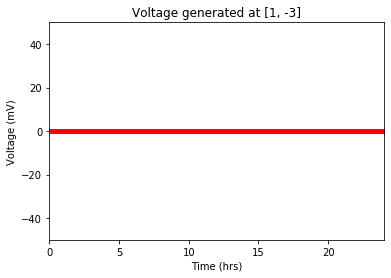

In [12]:
"""
convert temperature difference (core minus bark) to voltage

How to calculate the current (E) using the temperature difference. We will be 
using the Seebeck effect, so the calculation is super simple. E=-S*DeltaT. S 
is the Seebeck coefficient for wood, but the experimental project team already 
found this for us. So S=-0.259 mV/K if the outside temperature is colder than 
the tree (like night), and S=0.207 mV/K if the outside temperature is warmer 
than the tree [Cite Orlando Paper]. The DeltaT will be the difference between 
the core temperature and the bark temperature (in either C or K). The current 
you calculate E, will be in mV, and we should have a different value of E for 
each point in time we do the calculation for. 

Protasio Seebeck coeff: 48mV/K (material: bismuth telluride, for a semi conductor), 
no switch of sign

TEG model: SP1848-27145 TEG Peltier Module Thermoelectric Power Generator 

run voltage

"""

s1 = 0.207 # outside warmer
s2 = -0.259 # outside colder

E = solutionArrayD[:,0]

diff_at = parameters["diff_at"]
TempDiff = solutionArrayD[:, diff_at[0]] - solutionArrayD[:, diff_at[1]]

weather = make_weather_input(parameters)
airTemp = weather["air_temp"]

for j in range(len(E)):
    if airTemp[j] > E[j]:
        E[j] = -s1 * TempDiff[j]
    else:
        E[j] = -s2 * TempDiff[j]

print("Max and min temperature difference are ", TempDiff.max(), TempDiff.min(), "at time", np.argmax(TempDiff), np.argmin(TempDiff))
print("Max and min current are ", E.max(), E.min(), "at time", np.argmax(E), np.argmin(E))   

t = np.linspace(0, 24, E.size, endpoint=False) 

plt.plot(t, E, '.r-')
message = f"Voltage generated at {diff_at}"
plt.title(message)
plt.axis([0,24,-50,50])
plt.xlabel('Time (hrs)')
plt.ylabel('Voltage (mV)')
plt.savefig('/Users/yajuna/Development/tree/notebook/' + str(diff_at[0]) +str(diff_at[1]) + '.eps', format='eps', dpi=300,bbox_inches='tight')
plt.show()    
